In [1]:
import pandas as pd
from pathlib import Path
from simpful.gp_fuzzy_system.gp_evolution import genetic_algorithm_loop
from simpful.gp_fuzzy_system.auto_lvs import FuzzyLinguisticVariableProcessor


/Users/nikhilrazab-sekh/Desktop/simpful_btc/implementation/new_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [5]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Paths to the prepped data files
base_path = './data/prepped_data/'  # Adjusted base path to where our files are now
x_train_path = base_path + 'X_train.csv'
x_test_path = base_path + 'X_test.csv'
y_train_path = base_path + 'y_train.csv'
y_test_path = base_path + 'y_test.csv'

# Loading the datasets
x_train = pd.read_csv(x_train_path)
x_test = pd.read_csv(x_test_path)
y_train = pd.read_csv(y_train_path)
y_test = pd.read_csv(y_test_path)

# Inspect the 'value' column in x_train and x_test
print("First few rows of the 'value' column in x_train:")
print(x_train[['value']].head())

# Inspect the 'target' column in y_train
print("\nFirst few rows of the 'target' column in y_train:")
print(y_train.head())

# Check if 'value' column in x_train is the same as y_train
if x_train['value'].equals(y_train.squeeze()):
    print("\nThe 'value' column in x_train is the same as y_train.")
else:
    print("\nThe 'value' column in x_train is not the same as y_train.")

# Assuming the last columns of X_train and X_test are year, month, day, hour for reconstructing the datetime index
x_train['datetime'] = pd.to_datetime(x_train[['year', 'month', 'day', 'hour']])
x_test['datetime'] = pd.to_datetime(x_test[['year', 'month', 'day', 'hour']])
y_train.index = pd.to_datetime(x_train['datetime'])
y_test.index = pd.to_datetime(x_test['datetime'])

# Exclude non-numerical columns before scaling
columns_to_scale = x_train.columns.difference(['year', 'month', 'day', 'hour', 'datetime'])

# Initialize the scaler for the features
scaler_x = MinMaxScaler()

# Scale 'X' features (excluding non-numerical columns)
x_train_scaled = scaler_x.fit_transform(x_train[columns_to_scale])
x_test_scaled = scaler_x.transform(x_test[columns_to_scale])

# Initialize a separate scaler for the target variable
scaler_y = MinMaxScaler()

# Scale 'y' (the target variable)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert scaled arrays back to DataFrames for easier manipulation
x_train_scaled_df = pd.DataFrame(x_train_scaled, columns=columns_to_scale)
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=columns_to_scale)
y_train_scaled_df = pd.DataFrame(y_train_scaled, columns=['target'])
y_test_scaled_df = pd.DataFrame(y_test_scaled, columns=['target'])

# Add the datetime column back to the scaled dataframes
x_train_scaled_df['datetime'] = x_train['datetime'].values
x_test_scaled_df['datetime'] = x_test['datetime'].values
y_train_scaled_df['datetime'] = x_train['datetime'].values
y_test_scaled_df['datetime'] = x_test['datetime'].values

# Keep only the last value per day (closing prices)
x_train_daily = x_train_scaled_df.groupby(x_train_scaled_df['datetime'].dt.date).tail(1)
x_test_daily = x_test_scaled_df.groupby(x_test_scaled_df['datetime'].dt.date).tail(1)
y_train_daily = y_train_scaled_df.groupby(y_train_scaled_df['datetime'].dt.date).tail(1)
y_test_daily = y_test_scaled_df.groupby(y_test_scaled_df['datetime'].dt.date).tail(1)

# Create the folder "daily derived data from hour"
daily_data_path = './data/daily_derived_data_from_hour/'
os.makedirs(daily_data_path, exist_ok=True)

# Drop the 'datetime' column from x_train_daily
x_train_daily_dropped = x_train_daily.drop(columns=['datetime'])

# Drop the 'datetime' column from y_train_daily
y_train_daily = y_train_daily.drop(columns=['datetime'])

# Save the filtered datasets into the new folder
x_train_daily_dropped.to_csv(daily_data_path + 'x_train_daily.csv', index=False)
x_test_daily.to_csv(daily_data_path + 'x_test_daily.csv', index=False)
y_train_daily.to_csv(daily_data_path + 'y_train_daily.csv', index=False)
y_test_daily.to_csv(daily_data_path + 'y_test_daily.csv', index=False)

# Print the columns of x_train_daily_dropped and y_train_daily
print("Columns of x_train_daily_dropped:")
print(x_train_daily_dropped.columns)

print("\nColumns of y_train_daily:")
print(y_train_daily.columns)



First few rows of the 'value' column in x_train:
       value
0  44.431855
1  44.431855
2  44.431855
3  44.431855
4  44.431855

First few rows of the 'target' column in y_train:
    close
0  430.61
1  430.78
2  430.62
3  432.84
4  436.12

The 'value' column in x_train is not the same as y_train.
Columns of x_train_daily_dropped:
Index(['central_bank_policy_rate_prcnt', 'classification_numerical',
       'cpi_monthly', 'dia_close', 'dia_volume', 'domestic_credit_gdp',
       'durables_monthly', 'federal_funds_rate_daily',
       'foreign_direct_investment_value', 'gdp_growth_annual_prcnt',
       'gld_close', 'gld_volume',
       'individuals_using_the_internet_prcnt_of_population',
       'inflation_rate_value', 'macd',
       'mobile_cellular_subscriptions_per_100_people',
       'nonfarm_payroll_monthly', 'open',
       'personal_remittances_received_prcnt_of_gdp',
       'real_gdp_per_capita_quarterly', 'real_gdp_quarterly',
       'retail_sales_monthly', 'rsi', 'sma_30', 'spy_close

In [6]:
def run_genetic_algorithm(x_train, y_train_df, terms_dict_path, exclude_columns, population_size, max_generations, mutation_rate, crossover_rate, selection_method, tournament_size, elitism_rate, max_rules, min_rules, verbose):
    # Load the CSV data for training and predictions
    x_train = x_train_daily_dropped
    y_train = y_train_daily

    # Initialize the FuzzyLinguisticVariableProcessor
    processor = FuzzyLinguisticVariableProcessor(
        file_path='./data/daily_derived_data_from_hour/x_train_daily.csv', 
        terms_dict_path=terms_dict_path, 
        verbose=verbose, 
        exclude_columns=exclude_columns.split(',')
    )
    variable_store = processor.process_dataset()

    # Run the genetic algorithm loop with the provided arguments
    best_system, best_fitness_per_generation = genetic_algorithm_loop(
        population_size=population_size, 
        max_generations=max_generations, 
        x_train=x_train, 
        y_train=y_train, 
        variable_store=variable_store,
        selection_method=selection_method,
        tournament_size=tournament_size,
        crossover_rate=crossover_rate,
        mutation_rate=mutation_rate,
        elitism_rate=elitism_rate,
        max_rules=max_rules,
        min_rules=min_rules,
        verbose=verbose
    )
    
    # Report the best system found
    print("Best system found:")
    print(best_system)
    return best_system, best_fitness_per_generation

In [7]:
# Define the parameters
exclude_columns = 'month,day,hour'
terms_dict_path = './terms/terms_dict.py'
population_size = 10
max_generations = 4
mutation_rate = 0.5
crossover_rate = 0.8
selection_method = 'tournament'
tournament_size = 3
elitism_rate = 0.15
max_rules = 7
min_rules = 3
verbose = True

# Run the genetic algorithm
best_system, best_fitness_per_generation = run_genetic_algorithm(
    x_train_daily_dropped, y_train_daily, terms_dict_path, exclude_columns, 
    population_size, max_generations, mutation_rate, crossover_rate, 
    selection_method, tournament_size, elitism_rate, max_rules, min_rules, verbose
)

Failed to create linguistic variable for column 'central_bank_policy_rate_prcnt' with at least 2 terms
Failed to create linguistic variable for column 'classification_numerical' with at least 2 terms
Defined fuzzy set for term 'VERY_LOW' with points: 0.0, 0.0813076074745602, 0.23943220666078185
Defined fuzzy set for term 'LOW' with points: 0.0813076074745602, 0.23943220666078185, 0.36194780310527963
Defined fuzzy set for term 'MEDIUM' with points: 0.23943220666078185, 0.36194780310527963, 0.634692683603986
Defined fuzzy set for term 'HIGH' with points: 0.36194780310527963, 0.634692683603986, 0.8897672732011288
Defined fuzzy set for term 'VERY_HIGH' with points: 0.634692683603986, 0.8897672732011288, 1.0
Created linguistic variable for column 'cpi_monthly' with 5 terms
Defined fuzzy set for term 'VERY_LOW' with points: 0.006771460944947, 0.09479938234812472, 0.25105493985541066
Defined fuzzy set for term 'LOW' with points: 0.09479938234812472, 0.25105493985541066, 0.43793863182635534
De

Generations:  25%|████████████████████████████████████████▊                                                                                                                          | 1/4 [00:09<00:29,  9.95s/gen]

Refilled backup population with 30 new systems.
Original population size: 10
Number of elites: 1
Number of offspring: 8
New population size: 10
Generation 0: Best Fitness = 0.6537499831278252


Generations:  50%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 2/4 [00:21<00:21, 10.83s/gen]

Original population size: 10
Number of elites: 1
Number of offspring: 8
New population size: 10
Generation 1: Best Fitness = 0.6537499831278252


Generations:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 3/4 [00:34<00:11, 11.89s/gen]

Original population size: 10
Number of elites: 1
Number of offspring: 8
New population size: 10
Generation 2: Best Fitness = 0.6537499831278252


Generations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:51<00:00, 12.91s/gen]

Original population size: 10
Number of elites: 1
Number of offspring: 8
New population size: 10
Generation 3: Best Fitness = 0.6537499831278252


Best system found:


In [8]:
# Convert the list of tuples into a DataFrame
fitness_df = pd.DataFrame(best_fitness_per_generation, columns=['Generation', 'Best Fitness'])

# Display the DataFrame as a table
print(fitness_df)

   Generation  Best Fitness
0           0       0.65375
1           1       0.65375
2           2       0.65375
3           3       0.65375


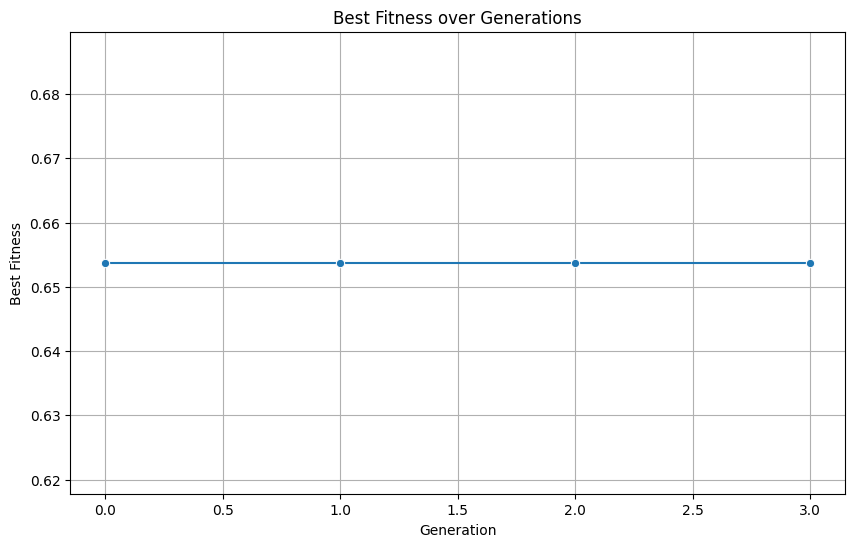

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming best_fitness_per_generation is a list of tuples [(generation, fitness), ...]
fitness_df = pd.DataFrame(best_fitness_per_generation, columns=['Generation', 'Best Fitness'])

# Plot the data using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=fitness_df, x='Generation', y='Best Fitness', marker='o')

# Set the title and labels
plt.title('Best Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')

# Show grid
plt.grid(True)

# Save the plot to a file
plt.savefig('fitness_over_generations.png')

# Display the plot
plt.show()